<a href="https://colab.research.google.com/github/rmorlowski/Artificial-Intelligence-Deep-Learning/blob/master/Reuters_News_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reuters Natural Language Processing - News Categorization

This assignment concerns natural language processing. You are asked to create deep neural networks for language processing and to analyze how various factors affect the fitting and ultimate test set performance of these networks.

![Reuters-logo](https://logos-download.com/wp-content/uploads/2016/05/Reuters_logo_emblem-700x168.png)

**The Benchmark Experiment:** Network Topologies. Think in terms of exploring alternative network structures/topologies, such as (1) dense versus convolutional neural networks, (2) single- versus multi-hidden-layer networks, and/or (3) convolutional neural networks with differing structures in terms of convolution and pooling layers. Explain your motivation for choosing each topology.

Relevant documentation includes:
*   [M. Chen - RNN with Reuters Dataset](https://medium.com/@minhao_chen/rnn-with-reuters-dataset-228ddc9d1f42)
*   [F. Chollet - Deep Learning with Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-one-hot-encoding-of-words-or-characters.ipynb)
*   [A. Geron - handson-ml2](https://github.com/ageron/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb)
*   [P. Huynh - reuters.py](https://canvas.northwestern.edu/courses/90349/pages/keras-tutorial-video-and-code-paul-huynh?module_item_id=1184249)
*   [Keras Documentation- Sequence Classfication with LSTM](http://faroit.com/keras-docs/0.3.3/examples/)
*   [Yale - Word Embeddings](http://euler.stat.yale.edu/~tba3/stat665/lectures/lec20/notebook20.html)

Among the network topologies (structures) you test in this assignment, there should be at least one network with the ability to take the sequence of words into consideration. A useful exercise is to compare processing requirements and predictive accuracy of dense versus recurrent neural networks with long short-term memory.

---



### Section 1: Ingest

The initial Reuters corpus has 10,788 documents from the Reuters financial newswire service, partitioned into a training set with 7769 documents and a test set with 3019 documents. The total size of the initial corpus is about 43 MB. The Reuters corpus may be used for various language tasks. A common task is text classification.

---


For this assignment we will develop a DNN, CNN, and RNN to predict the categories for news articles.

Check for GPU

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
#!/usr/bin/env python3 
!pip install -q keras   # This only required for Google's Colab
import keras
keras.__version__

'2.2.4'

In [0]:
!pip install numpy==1.16.1 #install old version of np
import numpy as np

Import packages

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers import SimpleRNN, LSTM
from keras.datasets import reuters

from sklearn.metrics import confusion_matrix, accuracy_score, auc

import pandas as pd
import seaborn as sns
import time as time
import matplotlib.pyplot as plt

**Reuters Dataset**

In [0]:
#loaded data
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words = 10000)

Gather data from Reuter's, load Train/Test split of the dataset in preparation for modeling.

In [0]:
#word index if desired to understand what each number represents
word_index = reuters.get_word_index(path="reuters_word_index.json")

### Section 2: EDA

**Explore Reuters data**

In [0]:
#How many training examples?
len(x_train)

8982

In [0]:
#How many test examples?
len(x_test)

2246

In [0]:
#How many classes?
num_classes = max(y_train) + 1
print('# of Classes: {}'.format(num_classes))

# of Classes: 46


In [0]:
#each example is a list of integers (word indices)
x_train[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [0]:
#decode it back to words, in case you're curious
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[10]])
print(decoded_newswire)

? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3


In [0]:
#label associated with an example is an integer between 0 and 45 -- a topic index:
y_train[10]

3

#### Prepare Data

In [0]:
#function used to transform the data into indivual documents to be fed into model
def vec_seq(seqs, dim = 10000):
    results = np.zeros((len(seqs), dim))
    for i, seq in enumerate(seqs):
        results[i,seq] = 1
    return results

In [0]:
#one hot encoding labels
def one_hot(labels, dim = 46):
    results = np.zeros((len(labels),dim))
    for i, label in enumerate(labels):
        results[i,label] = 1
    return results

In [0]:
#creating datasets to be used for model
x_train_seq = vec_seq(x_train)
x_test_seq = vec_seq(x_test)

y_train_one_hot = one_hot(y_train)
y_test_one_hot = one_hot(y_test)

In [0]:
max_features = 10000  # number of words to consider as features
batch_size = 64

### Section 3: Modeling

This is a text classification problem using the Reuters document collections introduced in chapter 3 of Chollet (2018) and demonstrated in the tutorial presented by Paul Huynh (under Modules / Technology Resources). Begin by fitting a fully connected (dense) network, evaluating alternative network structures in terms of their classification performance. Then pursue either a one-dimensional convolutional neural network (CNN) or a recurrent neural network (RNN or LSTM) to classify the same documents. Compare the performance of the word-sequence-enhanced model to the fully-connected model. Sequence models are discussed in chapter 6 of Chollet (2018

---



#### DNN Model

DNN Model - 1 hidden layer with a fully connected dense neural network, 20 epochs

In [0]:
#function to create model
def model():
    model = Sequential()
    model.add(Dense(100, input_dim = 10000, activation = 'relu'))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(46, activation ='softmax'))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [0]:
# Train the model
%%time
model = model()
history = model.fit(x_train_seq, y_train_one_hot, epochs = 20, batch_size = batch_size, verbose = True, validation_data=(x_test_seq, y_test_one_hot))

Train on 8982 samples, validate on 2246 samples
Epoch 1/20
8982/8982 [==============================] - 2s 174us/step - loss: 1.7119 - acc: 0.6426 - val_loss: 1.1481 - val_acc: 0.7382
Epoch 2/20
8982/8982 [==============================] - 1s 132us/step - loss: 0.7371 - acc: 0.8367 - val_loss: 0.9189 - val_acc: 0.7912
Epoch 3/20
8982/8982 [==============================] - 1s 132us/step - loss: 0.3980 - acc: 0.9134 - val_loss: 0.9164 - val_acc: 0.7939
Epoch 4/20
8982/8982 [==============================] - 1s 131us/step - loss: 0.2577 - acc: 0.9421 - val_loss: 0.9158 - val_acc: 0.8068
Epoch 5/20
8982/8982 [==============================] - 1s 133us/step - loss: 0.2038 - acc: 0.9492 - val_loss: 0.9586 - val_acc: 0.7974
Epoch 6/20
8982/8982 [==============================] - 1s 131us/step - loss: 0.1786 - acc: 0.9508 - val_loss: 1.0012 - val_acc: 0.7930
Epoch 7/20
8982/8982 [==============================] - 1s 132us/step - loss: 0.1575 - acc: 0.9525 - val_loss: 1.0052 - val_acc: 0.7965


In [0]:
# Print a summary of the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               1000100   
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 46)                2346      
Total params: 1,007,496
Trainable params: 1,007,496
Non-trainable params: 0
_________________________________________________________________
None


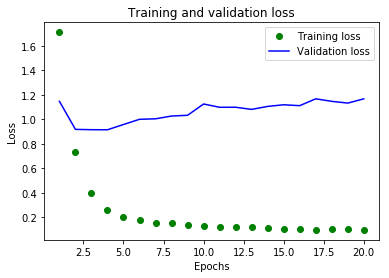

In [0]:
# Plotting the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

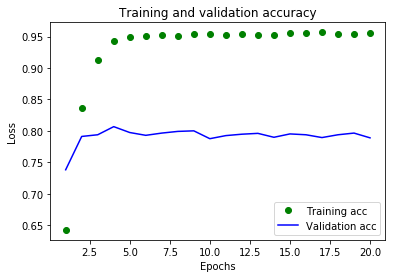

In [0]:
# Plotting the training and validation accuracy
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
#predictions
pred = model.predict_classes(x_test_seq)

In [0]:
#accuracy
accuracy_score(y_test,pred)

0.7889581478183437

In [0]:
#create confusion matrix
matrix = pd.DataFrame(confusion_matrix(y_test,pred, labels = [x for x in range(0,46)]))

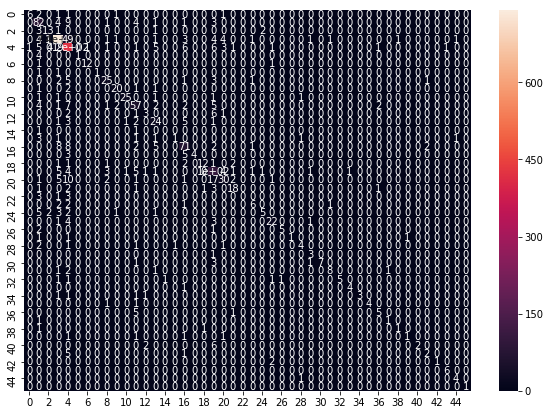

In [0]:
#visualize confusion matrix
plt.figure(figsize = (10,7))

sns.heatmap(matrix, annot=True)

#### Conv1D Model

We can use 1-dimensional convolutions to learn local associations between words, rather than having to rely on global associations.

In [0]:
#prep data for Conv1D model
X_train = sequence.pad_sequences(x_train, maxlen=100)
X_test = sequence.pad_sequences(x_test, maxlen=100)
Y_train = np_utils.to_categorical(y_train, 46)
Y_test = np_utils.to_categorical(y_test, 46)

In [0]:
model = Sequential()

# embedding
model.add(Embedding(500, 32, input_length=100))
model.add(Dropout(0.25))

# convolution layers
model.add(Convolution1D(nb_filter=32,
                        filter_length=4,
                        border_mode='valid',
                        activation='relu'))
model.add(MaxPooling1D(pool_length=2))

# dense layers
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Activation('relu'))

# output layer
model.add(Dense(46))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=32, kernel_size=4, padding="valid")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  if sys.path[0] == '':


In [0]:
%%time
history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=20, verbose=True, validation_data=(X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 8982 samples, validate on 2246 samples
Epoch 1/20
8982/8982 [==============================] - 1s 140us/step - loss: 0.0818 - acc: 0.9776 - val_loss: 0.0558 - val_acc: 0.9864
Epoch 2/20
8982/8982 [==============================] - 1s 80us/step - loss: 0.0517 - acc: 0.9870 - val_loss: 0.0502 - val_acc: 0.9875
Epoch 3/20
8982/8982 [==============================] - 1s 80us/step - loss: 0.0476 - acc: 0.9878 - val_loss: 0.0478 - val_acc: 0.9879
Epoch 4/20
8982/8982 [==============================] - 1s 82us/step - loss: 0.0434 - acc: 0.9884 - val_loss: 0.0441 - val_acc: 0.9882
Epoch 5/20
8982/8982 [==============================] - 1s 81us/step - loss: 0.0392 - acc: 0.9893 - val_loss: 0.0423 - val_acc: 0.9885
Epoch 6/20
8982/8982 [==============================] - 1s 82us/step - loss: 0.0588 - acc: 0.9873 - val_loss: 0.0442 - val_acc: 0.9881
Epoch 7/20
8982/8982 [==============================] - 1s 79us/step - loss: 0.0380 - acc: 0.9895 - val_loss: 0.0424 - val_acc: 0.9887
Epoch 

In [0]:
# Print a summary of the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           16000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 97, 32)            4128      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               393472    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
__________

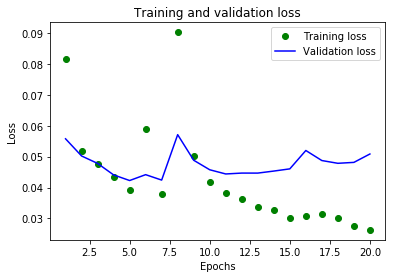

In [0]:
# Plotting the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

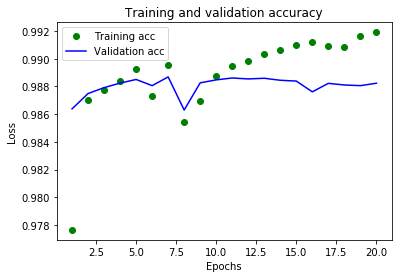

In [0]:
# Plotting the training and validation accuracy
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### RNN Model

In [0]:
model = Sequential()
model.add(Embedding(max_features, 64))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
%%time
history = model.fit(X_train, Y_train,
                    epochs=20,
                    verbose=True,
                    batch_size=batch_size,
                   validation_data=(X_test, Y_test))

Train on 8982 samples, validate on 2246 samples
Epoch 1/20
8982/8982 [==============================] - 19s 2ms/step - loss: 2.3892 - acc: 0.3734 - val_loss: 2.1760 - val_acc: 0.4510
Epoch 2/20
8982/8982 [==============================] - 17s 2ms/step - loss: 1.9636 - acc: 0.5011 - val_loss: 2.0896 - val_acc: 0.4577
Epoch 3/20
8982/8982 [==============================] - 17s 2ms/step - loss: 1.5119 - acc: 0.6182 - val_loss: 2.1066 - val_acc: 0.4648
Epoch 4/20
8982/8982 [==============================] - 17s 2ms/step - loss: 1.0954 - acc: 0.7258 - val_loss: 2.1341 - val_acc: 0.5236
Epoch 5/20
8982/8982 [==============================] - 19s 2ms/step - loss: 0.8024 - acc: 0.8033 - val_loss: 2.3670 - val_acc: 0.4777
Epoch 6/20
8982/8982 [==============================] - 18s 2ms/step - loss: 0.5972 - acc: 0.8602 - val_loss: 2.5891 - val_acc: 0.4381
Epoch 7/20
8982/8982 [==============================] - 18s 2ms/step - loss: 0.4552 - acc: 0.8937 - val_loss: 2.5168 - val_acc: 0.4849
Epoch 8

In [0]:
# Print a summary of the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 64)          8256      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 64)          8256      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 64)          8256      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 46)                2990      
Total params: 676,014
Trainable params: 676,014
Non-trainable params: 0
_________________________________________________________________
None

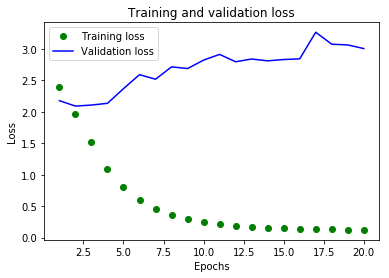

In [0]:
# Plotting the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

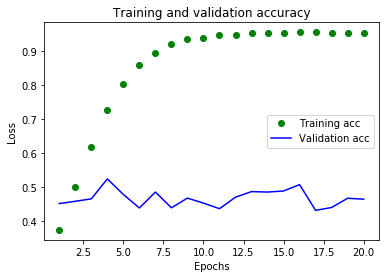

In [0]:
# Plotting the training and validation accuracy
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As we can see from the results, the accuracy of training the RNN model exponentially increases and the loss of it exponentially decreases as we have more epochs. The accuracy and loss of validation doesn’t perform very well. It might caused by overfitting.

#### RNN with LSTM Model

In [0]:
model = Sequential()
model.add(Embedding(max_features, 64))
model.add(LSTM(output_dim=64, activation='sigmoid', recurrent_activation='hard_sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="sigmoid", recurrent_activation="hard_sigmoid", units=64)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
%%time
history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=20, validation_data=(X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 8982 samples, validate on 2246 samples
Epoch 1/20
8982/8982 [==============================] - 21s 2ms/step - loss: 2.5092 - acc: 0.3409 - val_loss: 2.1120 - val_acc: 0.3673
Epoch 2/20
8982/8982 [==============================] - 20s 2ms/step - loss: 2.0287 - acc: 0.4388 - val_loss: 1.8664 - val_acc: 0.5027
Epoch 3/20
8982/8982 [==============================] - 21s 2ms/step - loss: 1.8201 - acc: 0.5120 - val_loss: 1.7584 - val_acc: 0.5419
Epoch 4/20
8982/8982 [==============================] - 20s 2ms/step - loss: 1.7405 - acc: 0.5487 - val_loss: 1.7696 - val_acc: 0.5312
Epoch 5/20
8982/8982 [==============================] - 20s 2ms/step - loss: 1.6855 - acc: 0.5620 - val_loss: 1.7478 - val_acc: 0.5499
Epoch 6/20
8982/8982 [==============================] - 20s 2ms/step - loss: 1.6414 - acc: 0.5714 - val_loss: 1.6630 - val_acc: 0.5721
Epoch 7/20
8982/8982 [==============================] - 21s 2ms/step - loss: 1.5971 - acc: 0.5794 - val_loss: 1.6483 - val_acc: 0.5752
Epoch 8

In [0]:
# Print a summary of the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 46)                2990      
Total params: 676,014
Trainable params: 676,014
Non-trainable params: 0
_________________________________________________________________
None


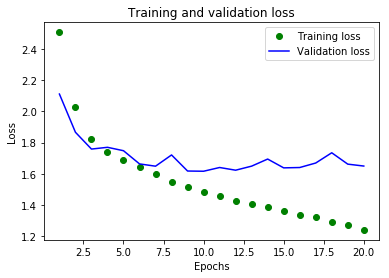

In [0]:
# Plotting the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

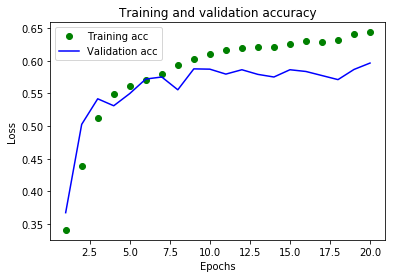

In [0]:
# Plotting the training and validation accuracy
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
score = model.evaluate(X_test, Y_test, batch_size=batch_size)
print(score)

2246/2246 [==============================] - 1s 501us/step
[1.6492353330630865, 0.5966162066425686]


### Section 4:  Conclusion

**Management problem:** Suppose you are asked by your current employer to develop a conversational agent or chatbot to assist customer support representatives. What advice would you give management about such development? What kinds of methods and models would be needed?  Would this be a substantial development project? Do you have any ideas about the information infrastructure needed to support conversational agents in a production environment?


>>>> **Summary Table:**



>Model Type | Number of Layers | Number of Epochs | Processing Time | Test Accuracy
>--- | --- | --- | --- | ---
>DNN | 3 | 20| 12.1sec | 0.7903
>CNN | 4 | 20| 32.7sec | 0.9865
>RNN | 4 | 20| 6min 5sec | 0.4639
>LSTM | 3 | 20| 7min 50sec | 0.6428

**In Conclusion:**

After fitting a number of neural networks, processing time and performance was compared across experimental treatments.

The results showed:

*    The Conv1D model performed well for processing temporal patterns. They offer a fast alternative to RNNs for natural language processing.
*    The DNN and Conv1D one-hot-encoded models achieved solid performance while remaining computationally cheap.
*    The RNN and LSTM models processed sequences over time, but were relatively expensive compared to the DNN and Conv2D models and did not lead to greater accuracy.

In summary, to address management, developing a conversational agent or chatbot to assist customer support representatives is a challenging undertaking. The Conv1D model was able to learn local associations between words, rather than having to rely on global associations. Using pretrained word embeddings may be a helpful way to reduce dimensionality and increase the chatbot vocabulary, but is outside the scope of this analysis. The network architecture is a key element in building a neural network model for natural language processing especially selection of the types of layers. The final recommendation is to implement the Conv1D model for text categorization. However, gated recurrent unit (GRU) or LSTM models may be more appropriate for sequenced text data generation and remain topics for future study. The Conv1D model takes less time to process than the recurrent and LSTM models, results in the most accurate predictions, and is the most trustworthy.